In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score

# Do not show warnings
import warnings
warnings.filterwarnings("ignore")

#Read the csv files and save them in dataframes
df_train=pd.read_csv('df_train.csv',low_memory=False)
df_test=pd.read_csv('df_test.csv',low_memory=False)

In [2]:
# Create list of features which are binarized or boxcox/logarithmic transformation of some numerical features
feature_list_1 = [feature for feature in df_train.columns if ('transformed' in feature) | ('zero' in feature)]

# Create list of features from which binarized or boxcox/logarithmic format were created
feature_list_2 = [feature.replace('_zero','').replace('_transformed','') for feature in feature_list_1]

# Create two train sets: one does not include features_list_2, the other one does not include feature_list_1
# The first one will be used in logistic regression, the second one will be used in xgboost classifier
# because some initial analysis indicated each classifier shows better results with its corresponding train set
df1 = df_train.drop(feature_list_2, axis=1) # Transformed format of features will be used in the logistic regression
df2 = df_train.drop(feature_list_1, axis=1) # Original format of features will be used in the xgboost classifier

In [3]:
# Create feature dataframe from both train sets
X1 = df1.drop('charged_off',axis=1) # Feature dataframe 1
X2 = df2.drop('charged_off',axis=1) # Feature dataframe 2

# Create response variable series of the train set
y_train = df_train.loc[:,'charged_off'] #Response variable is the same for both train sets

In [4]:
# Print number of features in each train set
len(X1.columns)

64

In [5]:
# Show the ratio of paid-off (0) and charged-off (1) loans in the response variable
y_train.value_counts(normalize=True)

0    0.798852
1    0.201148
Name: charged_off, dtype: float64

In [6]:
# Convert categorical features to dummy variables
X1_train = pd.get_dummies(X1)
X2_train = pd.get_dummies(X2)

# Drop one level from each categorical feature. The level which has middle charged-off ratio across all levels is picked.
# For instance, among loan grades, as the grade goes from A to F, the charge-off ratio goes higher.
# In other words, grade D has the middle charged-off ratio and is removed (check the bar plot of grade in EDA1).
# If there is only two levels in a feature, the level with lower ratio is removed.

dummy_drop_list =['term_ 36 months','grade_D','home_ownership_OTHER','verification_status_Source Verified','purpose_other',
              'addr_state_AK','application_type_Individual','disbursement_method_Cash']

# Remove features in dummy_drop_list from the two train sets
X1_train.drop(dummy_drop_list,axis=1,inplace=True)
X2_train.drop(dummy_drop_list,axis=1,inplace=True)

In [46]:
# Print number of features in X1_train after creating dummy variables
print('X1_train has {} features'.format(len(X1_train.columns)))

X1_train has 133 features


In [8]:
# Three stratified folds are defined to be used as cross-validation splitting strategy. Since the train set is quite large, 
# 3-fold is used instead of typical 5-fold strategy to speed up the cross validation processes.
kfolds = StratifiedKFold(n_splits=3,random_state=21) 

# Define standard scaler
scaler = StandardScaler()

#### The machine learning process starts with logistic regression because of its simplicity. Scikit learn recommends to use stochastic gradient descent (SGD) for large scale data. The downside of SGD is it requires tuning several parameters to provide good results. Therefore, it is decided to use logistic regression but with ‘sag’ solver which is stochastic average gradient descent. The data set must be scaled before using the ‘sag’ solver. Also, class_weight parameter of the classifier is set to 'balanced' to address imbalance dataset. The model is built by deploying a pipeline of scaler and classifier. As a reminder, the model showed  better accuracy scores with X1_train set than X2_train.

In [8]:
# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Run cross-validation with accuracy scroing
scores = cross_val_score(pipeline,X1_train,y_train,cv=kfolds,scoring='accuracy')

In [9]:
# Print the average of the three scores
print('The average of 3-fold cross-validation accuracy scores for the logistic regression is %.3f '%np.mean(scores))

The average of 3-fold cross-validation accuracy scores for the logistic regression is 0.656 


In [10]:
# Tune parameter C

# Define LogisticRegressionCV with accuracy scoring.
clf=LogisticRegressionCV(Cs=np.logspace(-2,2,5),class_weight='balanced',solver='sag',cv=kfolds,scoring='accuracy',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Fit the pipeline to the train set
pipeline.fit(X1_train,y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
           class_weight='balanced',
           cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=False),
      ...  random_state=21, refit=True, scoring='accuracy', solver='sag',
           tol=0.0001, verbose=0))])

In [11]:
# Access to LogisticRegressionCV
regcv = pipeline.steps[1][1]

# Print the best C
print('Best C is ',regcv.C_)

# Print the average of scores for each C value
print('The average of the three scores for each C value:\n',regcv.scores_[1].mean(axis=0))

Best C is  [0.1]
The average of the three scores for each C value:
 [0.65581291 0.65581291 0.65579502 0.65579712 0.65580133]


#### Although the best C value is 0.1, average of the three scores across the five C values are within less than 0.001 of each other. Therefore, the default value C=1 will be kept. 

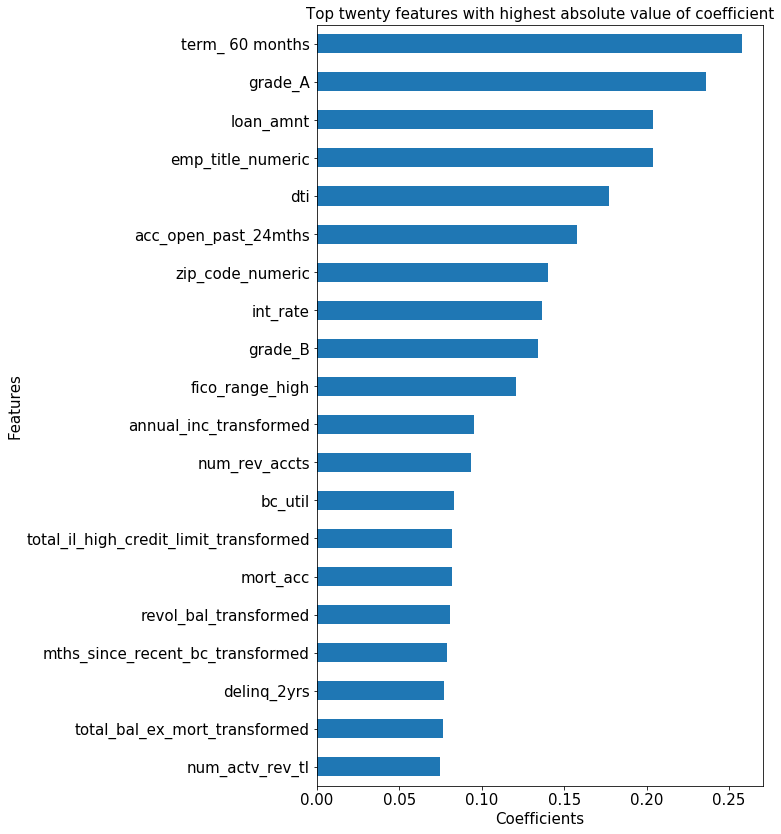

In [14]:
# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Fit the pipeline to the train set
pipeline.fit(X1_train,y_train)

# Create dataframe of feature coefficients
feature_df = pd.DataFrame(np.transpose(np.abs(pipeline.steps[1][1].coef_)),columns=['coefficient'],index=X1_train.columns)\
.sort_values(by='coefficient')

# Plot top twenty features with highest absolute value of coefficients. Since the features are scaled,
# the absolute coefficient value represents feature importance.
feature_df.iloc[-20:].plot.barh(figsize=(8,14),legend=False)
plt.xlabel('Coefficients',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Top twenty features with highest absolute value of coefficient',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.show()

In [ ]:
# The impact of loan term and loan grade on the loan status was analyzied in EDA1 in details

In [16]:
# In order to analyze the important numerical features, they are discretized and the charged-off ratio across each bin
# is claculated and plotted
def binning(feature,bins,df):
    """This function discretize the specified feature of df based on the bins parameter and generates
    a bar plot which shows the charged-off ratio across the bins"""
    df_copy = df.loc[:,[feature,'charged_off']]
    df_copy[feature+'_bins']=pd.cut(df_copy[feature],bins=bins).astype('str').str.replace('(','').str.replace(']','').str.replace(', ','_')
    listt=['{}_{}'.format(np.round(float(bins[m]),2),np.round(float(bins[m+1]),2))for m in range(len(bins)-1)]
    group=df_copy.groupby(feature+'_bins')['charged_off'].mean()
    group.loc[listt].plot.barh(figsize=(10,8))
    plt.ylabel(feature+'_bins',fontsize=15,x=1.08)
    plt.yticks(fontsize=15)
    plt.xticks(rotation='horizontal',fontsize=15)
    plt.xlabel('charged_off ratio',fontsize=15)
    plt.title('charged_off ratio across all levels of {}'.format(feature+'_bins'),fontsize=15)
    plt.show()

In [32]:
pd.cut(df2['int_rate'],bins=bins).astype('str').str.replace('(','').str.replace(']','').str.replace(', ','_').head()

0    10.0_15.0
1    20.0_25.0
2     5.0_10.0
3    15.0_20.0
4     5.0_10.0
Name: int_rate, dtype: object

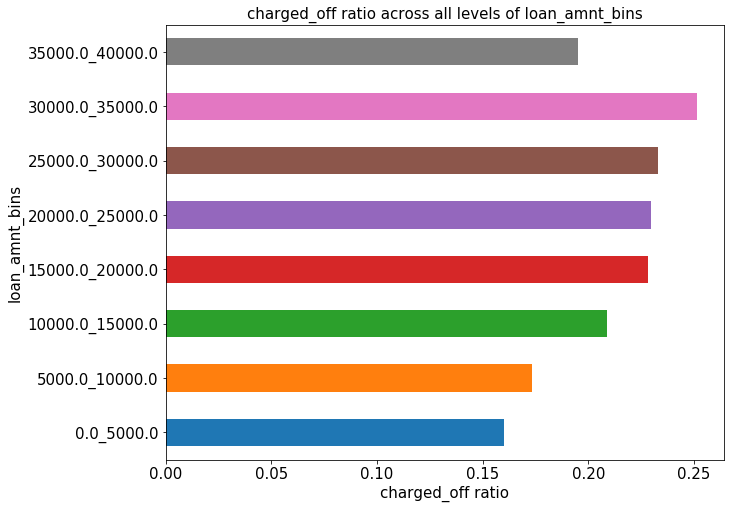

In [42]:
# Apply binning function on loan amount
bins=np.arange(0.0,40001.0,5000.0)
binning('loan_amnt',bins,df1)

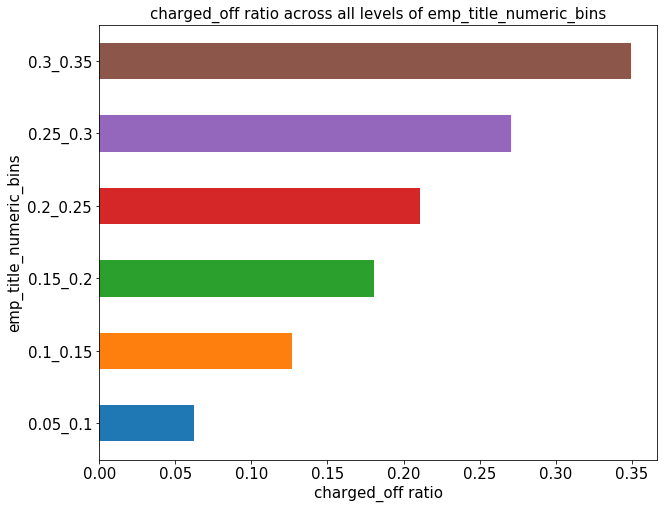

In [41]:
# Apply binning function on numeric employment title
bins=np.arange(0.05,0.36,0.05)
binning('emp_title_numeric',bins,df1)

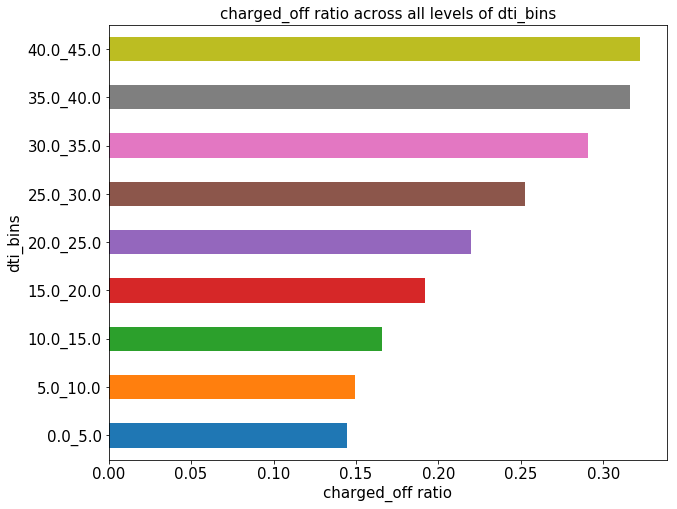

In [21]:
# Apply binning function on debt to income ratio (dti)
bins=np.arange(0,46.0,5.0)
binning('dti',bins,df1)

In [9]:
# Add interaction terms. There are 133 features after creating dummy variables. Adding interaction terms between all of them
# make the model too complex. 50 features are dummy variables of states. Since these variables do not have
# large coefficients, they are removed before adding interaction terms.

new_feature_list = [feature for feature in X1_train.columns if 'addr_state' not in feature]
X1_train_new = X1_train.loc[:,new_feature_list]

# Define interaction terms
interaction = PolynomialFeatures(degree = 2,interaction_only=True)

# Define pipeline
pipeline = make_pipeline(interaction,scaler,clf)

# Run cross-validation 
scores = cross_val_score(pipeline,X1_train_new,y_train,cv=kfolds,scoring='accuracy')

#print results
print('The average 3-fold cross-validation accuracy scores for the logistic regression with interaction terms is %.3f '
      %np.mean(scores))

#### The average cross-validation accuracy score improved only by 0.002. Therefore, the interaction terms will not be added to the logistic regression model.

In [9]:
# Plot ROC curve for the train data set

# Classifier
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# Pipeline
pipeline = make_pipeline(scaler,clf)

# Fit pipeline to train set
pipeline.fit(X1_train,y_train)

# Predict the response variable of the train set
y_predict = pipeline.predict(X1_train)

# Compute the recall score and round it to three digits
recall_score = np.round(recall_score(y_train,y_predict),3)

# Compute probability estimates
y1_predict_proba = pipeline.predict_proba(X1_train)

# Compute true positive ratio (recall) and false positive ratio across different thresholds
fpr, tpr, thresholds = roc_curve(y_train,y1_predict_proba[:,1])

# Find the false positive ratio corresponding to recall score
a = np.argwhere(np.round(tpr,3)==recall_score)[0]
b = np.float(fpr[a])

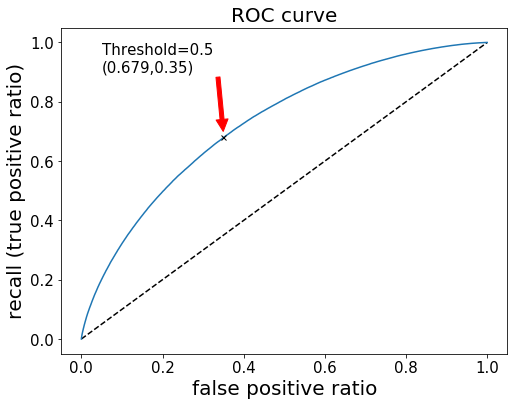

In [10]:
# Plot ROC curve and the point corresponding to threshold  = 0.5
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.plot(b,recall_score+0.002,marker='x',markersize=5,color='black')
plt.annotate('Threshold=0.5 \n(%.3f,%.2f)'%(recall_score,b),(b,0.7),(0.05,0.9),arrowprops={'color':'red'},fontsize=15)
plt.xlabel('false positive ratio',fontsize=20)
plt.ylabel('recall (true positive ratio)',fontsize=20)
plt.title('ROC curve',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### According to the plot, increasing or decreasing the threshold will have quite similar impact on recall and false positive ratio in a wide range of thresholds. It could be concluded that changing the threshold will not have a considerable impact on the accuracy. Therefore, the threshold will not be changed.

#### Conclusion: The final logistic regression classifier has the following parameters: class_weight='balanced', solver='sag', and C=1. The average 3-fold cross-validation accuracy score of the classifier is 0.656.

#### It was necessary to make several data transformation on numerical features because of the special distribution of each feature. Tree-based models are robust to data distributions. Therefore, an XGBoost classifier is developed in the next section.

# XGBoost Classifier

In [9]:
# Define classifier 
clf = XGBClassifier(scale_pos_weight=4,random_state=21)

# Run cross validation
scores = cross_val_score(clf,X2_train,y_train,cv=kfolds,scoring='accuracy')

In [10]:
# Print the average of results
print('The average of 3-fold cross-validation accuracy scores for the XGBoost classifier is %.3f '%np.mean(scores))

The average of 3-fold cross-validation accuracy scores for the XGBoost classifier is 0.651 


#### Five parameters of the XGBoost classifier are tuned based on the following values: n_estimators: {20,50,100}, learning_rate: {0.05,0.1,0.2}, max_depth: {3,4,5}, subsample:{0.6,0.8,1}, and colsample_bytree:{0.4,0.7,1}. Since the dataset is quite large, the parameters are tuned one by one. The process starts with the number of estimators and assigns the rest of parameters to the middle value of their corresponding set.

In [10]:
# Define a function which receives classifier, parameter values, cross-validation folds, features and response 
# variable of trainset as inputs, tunes hyper parameters and prints the best score and best parameter value

def tuning(classifier,param_set,cv_folds=kfolds,train_feature=X2_train,train_response=y_train):
    """This function tunes hyper parameters of the classifier. The hyper parameters are defined by param_set.
    The tuning is performed by GridSearchCV with folds defined by cv_folds."""
    model = GridSearchCV(classifier,param_grid=param_set,cv=cv_folds,scoring='accuracy') 
    model.fit(train_feature,train_response)
    print('The best score in parameter tuning is: %.3f'%model.best_score_)
    print('The best parameter value is: ',model.best_params_)    
    return model

In [12]:
# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,learning_rate=0.1,max_depth=4,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'n_estimators':[20,50,100]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.654
The best parameter value is:  {'n_estimators': 100}


In [13]:
# Print the mean of test scores for each value of n_estimators 
cv.cv_results_['mean_test_score']

array([0.63042666, 0.64679677, 0.65356651])

In [14]:
# Since the highest score is the largest value in the set, parameter tuning is run again with a new set which is {100,200,500}.
parameter = {'n_estimators':[100,200,500]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.665
The best parameter value is:  {'n_estimators': 500}


In [15]:
# Print the mean of test scores for each value of n_estimators 
cv.cv_results_['mean_test_score']

array([0.65356651, 0.65912883, 0.66541223])

In [16]:
# The highest score belongs to n_estimators of 500, but the score is only 0.01 more than the score of n_estimators of 100. 
# Therefore, the parameter is set to 100 to keep the computation process faster.

# Tune learning_rate

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,max_depth=4,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'learning_rate':[0.05,0.1,0.2]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.659
The best parameter value is:  {'learning_rate': 0.2}


In [17]:
# Print the mean of test scores for each value of learning_rate 
cv.cv_results_['mean_test_score']

array([0.64749785, 0.65356651, 0.65931726])

In [13]:
# Again, since the highest score is the largest value in the set,parameter tuning is run again with a new set {0.2,0.3,0.5}. 
parameter = {'learning_rate':[0.2,0.3,0.5]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.661
The best parameter value is:  {'learning_rate': 0.5}


In [14]:
# Print the mean of test scores for each value of learning_rate 
cv.cv_results_['mean_test_score']

array([0.65931726, 0.66044783, 0.66100574])

In [15]:
# The score goes up very slowly as the learning_rate goes up (the score of learning_rate of 0.2 is only 0.002 less than 
# the score of learning_rate of 0.5). Therefore, the learning_rate values beyond 0.5 will not be tested
# Learning_rate = 0.5

# Tune max_depth.

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.5,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'max_depth':[3,4,5]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.664
The best parameter value is:  {'max_depth': 5}


In [16]:
# Print the mean of test scores for each value of max_depth
cv.cv_results_['mean_test_score']

array([0.65883724, 0.66100574, 0.66357111])

In [17]:
# Again, since the score goes up very slowly as the max_depth goes up, values beyond 5 will not be tested.
# max_depth = 5

#Tune subsample

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.5,max_depth=5,colsample_bytree=0.7)

# Define parameter
parameter = {'subsample':[0.6,0.8,1]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.665
The best parameter value is:  {'subsample': 1}


In [18]:
# Print the mean of test scores for each value of subsample 
cv.cv_results_['mean_test_score']

array([0.66101943, 0.66357111, 0.6647501 ])

In [11]:
# subsample = 1

# Tune colsample_bytree

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.5,max_depth=5,subsample=1)

# Define parameter
parameter = {'colsample_bytree':[0.4,0.7,1]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.665
The best parameter value is:  {'colsample_bytree': 1}


In [12]:
# Print the mean of test scores for each value of colsample_bytree
cv.cv_results_['mean_test_score']

array([0.66399218, 0.6647501 , 0.66495853])

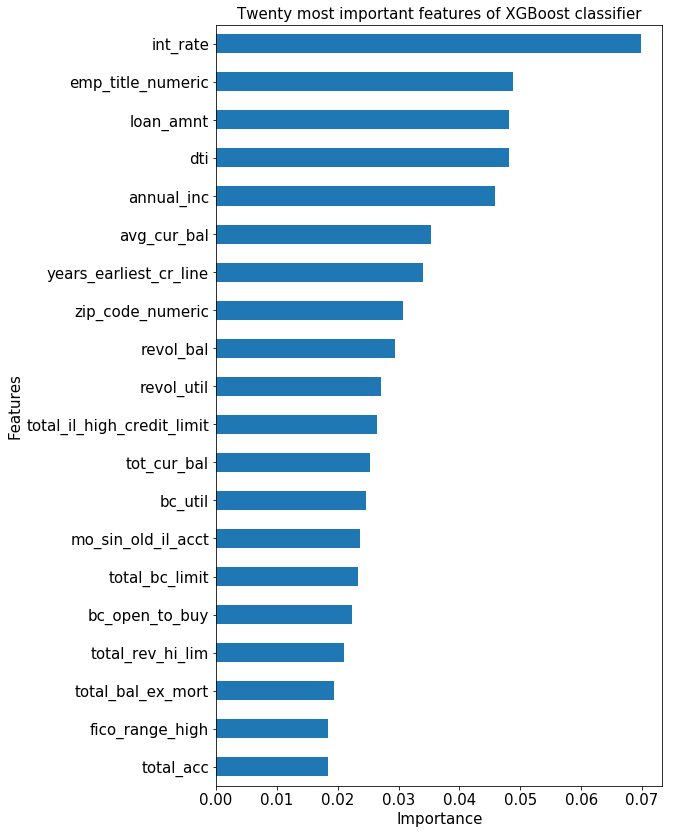

In [13]:
# colsample_bytree = 1

# Define the classifier with tuned parameters
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.5,max_depth=5,subsample=1
                    ,colsample_bytree=1)

# Fit the classifier to the train set
clf.fit(X2_train,y_train)

# Plot the feature importance diagram of top 20 most important features.
features = pd.DataFrame(clf.feature_importances_, index = X2_train.columns,
                            columns=['importance']).sort_values('importance',ascending=True)

features.iloc[-20:].plot.barh(figsize=(8,14),legend = False)
plt.xlabel('Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title ('Twenty most important features of XGBoost classifier',fontsize=15)
plt.show()

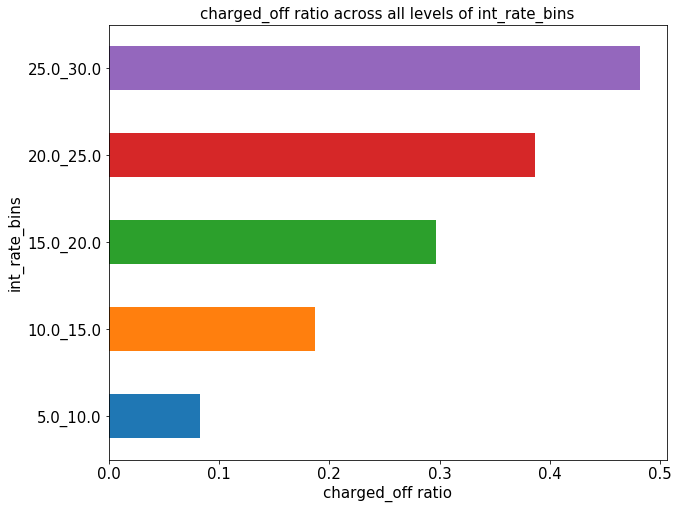

In [36]:
# Among the five most important features, numeric employment title, loan amount and dti were analyzed before by applying
# binning function on them

# Apply binning function on interest rate
bins=np.arange(5.0,31.0,5.0)
binning('int_rate',bins,df2)

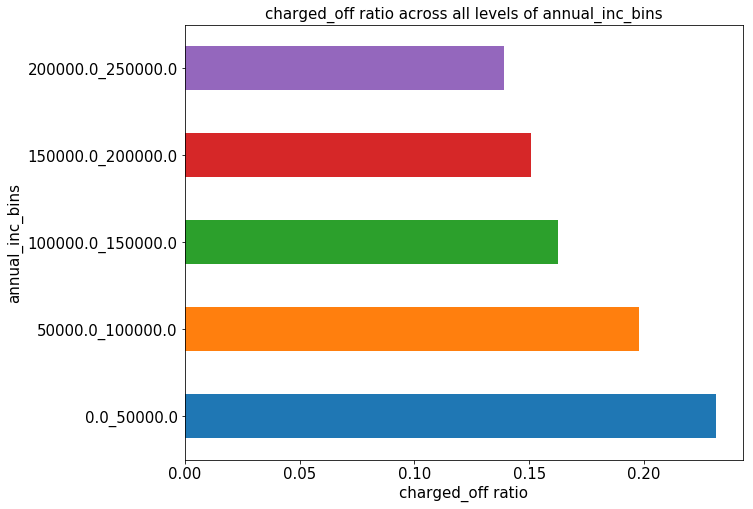

In [41]:
# Apply binning function on annual income
bins=np.arange(0.0,250001,50000)
binning('annual_inc',bins,df2)

### Final Model: The average 3-fold cross-validation accuracy score of the XGBoost classifier after tuning hyper parameters is 0.665 which is only 1.4% more than the score of the logistic regression model which is 0.656. Since the logistic regression model is simpler and more interpretable, it is selected as the final model.

### Find the accuracy score of the test set.

In [43]:
# Create the test set
df_test_1 = df_test.drop(feature_list_2, axis=1) 

# Create feature dataframe from the test set
X1_test = df_test_1.drop('charged_off',axis=1) 

# Create response variable series of the test set
y_test = df_test.loc[:,'charged_off']

# Convert categorical features to dummy variables
X1_test = pd.get_dummies(X1_test)

# Drop one level from each categorical feature 
X1_test.drop(dummy_drop_list,axis=1,inplace=True)

In [45]:
# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Fit the pipeline on the train set
pipeline.fit(X1_train,y_train)

# Predict the response variable of the test set
y_predict = pipeline.predict(X1_test)

# Print recall and accuracy scores of the test set
print('The accuracy score of the test set is %.3f'%accuracy_score(y_test,y_predict))

The accuracy score of the test set is 0.655


### Accuracy score of the test set is only 0.001 less than the average 3-fold cross-validation accuracy score of the train set.